# Assignment 1

# Homework
Apply our decision tree algorithm to a research dataset. Compute the entropy of the dataset. Create a decision tree model and score the model, and then a random forest model from `sklearn`. Make sure not to learn a model by heart (overfit)! *Explain* (interpret) the model: If you were to give another human instructions for how to predict, what `if-then-else` *instructions* would you give them?

>**Rubrik**: Your homework will not be graded based on how well you predict, we already know that when the dataset is predictable with *if-then-else* considerations (i.e. information entropy considerations), decision tress and random forests can do a pretty good job. Instead, your homework will be graded based on how *small* your model is relative to the number of options. Think about it as how *explainable* your model is (what model do you think it better: (*turn right*, or "*turn left, then left again, and finally another left*?. Overfit and you get a not-so-good grade. Underfitting is better than overfitting. But getting it *just right* is best.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from simple_ml import entropy
import pickle
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

## Reading dataset

Combining the data from 3 files into a single dataframe

In [2]:
all_filenames = ['MI_14840_2013Fall_2014Spring.csv', 'IL_94846_2013Fall_2014Spring.csv', 'IN_04846_2013Fall_2014Spring.csv']
combined_df = pd.concat([pd.read_csv(f) for f in all_filenames ])
combined_df.shape

(13106, 37)

## Data Pre Processing

Removing following columns : <br>
1. All date and time columns as they do not provide any information regarding the prediction we want achieve here.<br>
2. Peak Wind Gust and Cloud heights as they have maximum noisy (m,M) values which might skew the prediction in certain direction.<br>
3. WInd Chill and Heat Index as they have only dirty ('NC') data.<br>
4. Selected as it just have a single value in it

In [3]:
remove_col = ['Date','Time', 'Date_CST', 'Time_CST',
              'Peak Wind Gust(mph)','Altimeter (hPa)','Low Cloud Ht (ft)','Med Cloud Ht (ft)','High Cloud Ht (ft)',
              'Date_UTC_x', 'Time_UTC_x','Date_UTC_y', 'Time_UTC_y',
              'Wind Chill (F)','Heat Index (F)', 'Selected']
combined_df = combined_df.drop(remove_col, axis = 1) 
combined_df = combined_df.reset_index(drop=True)

Renaming column names by replacing spaces by underscores and removing brackets 

In [4]:
combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_7028/1933743343.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/pw/kjv2697x6q18wbdd7j7x8w_00000gn/T/ipykernel_7028/1933743343.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  combined_df.columns = combined_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')


Romoving nulls and other noisy values - M,m,NC

In [5]:
combined_df = combined_df[combined_df.lake_visible != ""]
combined_df = combined_df[combined_df.les_exist != ""]
combined_df = combined_df[combined_df.temp_f != ""]
combined_df = combined_df[combined_df != ""]
combined_df = combined_df[combined_df != "M"]
combined_df = combined_df[combined_df != "m"]
combined_df = combined_df.dropna()

In [6]:
combined_df.head(5)

,temp_f,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,atm_press_hpa,sea_lev_press_hpa,precip_in,mean,...,centroid_lat,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist
0,58,77,51,8,160,10,989.90,1012.60,0.00,0.001979,...,43.976425,0.665668,1.226432,0.582646,0.007014,2.816020,1.711882,3.0,N,N
1,58,80,52,6,160,10,990.20,1013.10,0.00,0.002175,...,43.944432,0.670232,1.239065,0.660357,0.030175,2.863913,1.689899,4.0,N,N
2,57,86,53,5,160,10,990.20,1013.20,0.00,0.007346,...,43.926699,0.649593,1.235327,0.630409,0.023720,2.893504,1.712862,4.0,N,N
3,63,86,59,9,190,10,990.20,1013.00,0.00,0.001971,...,43.931263,0.656606,1.235076,0.614300,0.024125,2.869601,1.716328,3.0,N,N
4,64,86,60,9,190,10,990.20,1013.10,0.00,0.008081,...,43.771260,0.625056,1.225389,0.684025,0.192531,3.150438,1.765415,4.0,N,N


Looking for unquie values in the columns

In [7]:
for col in combined_df:
  print(combined_df[col].unique())

['58' '57' '63' '64' '65' '66' '67' '68' '70' '71' '69' '61' '51' '55'
 '72' '74' '75' '73' '60' '56' '59' '54' '53' '50' '49' '48' '52' '46'
 '44' '47' '62' '45' '43' '41' '40' '38' '39' '42' '35' '36' '37' '34'
 '31' '32' '30' '29' '28' '27' '26' '33' '25' '23' '24' '21' '20' '19'
 '22' '18' '13' '15' '16' '17' '14' '9' '12' '11' '7' '8' '6' '5' '4' '2'
 '10' '-0' '-1' '1' '3' '-2' '-4' '-7' '-6' '-5' '77' '78' '79' '76' '80'
 '-3' '-8' '-10' '-12' '-13' '-15' '-16' '-14' '-11' '-9' '81']
['77' '80' '86' '90' '89' '87' '83' '84' '81' '75' '73' '70' '78' '93'
 '92' '60' '45' '35' '26' '37' '36' '33' '38' '62' '64' '74' '59' '63'
 '71' '69' '72' '76' '51' '68' '66' '61' '57' '55' '82' '85' '79' '50'
 '52' '58' '56' '43' '42' '48' '54' '88' '34' '39' '40' '41' '31' '29'
 '49' '46' '47' '53' '67' '65' '44' '32' '30' '23' '96' '100' '95' '91'
 '28' '27' '25' '24' '94']
['51' '52' '53' '59' '60' '61' '62' '57' '56' '49' '47' '43' '37' '38'
 '46' '45' '44' '48' '50' '63' '65' '66' '64' '68'

We can see that only last two columns (lake_visible and les_exist) contain categorical data. Others have numerical values.
So we will convert those column values to continuous values by replacing 'Y' by 1 and 'N' by 0.

In [8]:
combined_df['lake_visible'] = combined_df['lake_visible'].replace(to_replace=r'N', value=r'0', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'Y', value=r'1', regex=True)
combined_df['les_exist'] = combined_df['les_exist'].replace(to_replace=r'N', value=r'0', regex=True)

Further we will typecast all the column values to numeric dtype

In [9]:
combined_df.iloc[:,:] = combined_df.iloc[:,:].apply(lambda x : pd.to_numeric(x , errors = 'coerce'))

In [10]:
combined_df.shape

(11974, 21)

## Adding Target Column

Adding the target column (LES_SNOWFALL) to the dataset.
Condition = if Temp < 32 and Precip > 0 then Y (1) else N (0)

In [11]:
combined_df['les_snowfall'] = np.where((combined_df['temp_f'] <= 32) & (combined_df['precip_in'] > 0), 1, 0)

We will also drop Temp and Prcip columns to prevent the bias in the model

In [12]:
combined_df = combined_df.drop(['temp_f','precip_in'], axis = 1) 
combined_df.head()

,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,atm_press_hpa,sea_lev_press_hpa,mean,centroid_lon,centroid_lat,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall
0,77,51,8,160,10,989.9,1012.6,0.001979,-86.711706,43.976425,0.665668,1.226432,0.582646,0.007014,2.816020,1.711882,3.0,0.0,0,0
1,80,52,6,160,10,990.2,1013.1,0.002175,-86.728150,43.944432,0.670232,1.239065,0.660357,0.030175,2.863913,1.689899,4.0,0.0,0,0
2,86,53,5,160,10,990.2,1013.2,0.007346,-86.727714,43.926699,0.649593,1.235327,0.630409,0.023720,2.893504,1.712862,4.0,0.0,0,0
3,86,59,9,190,10,990.2,1013.0,0.001971,-86.732769,43.931263,0.656606,1.235076,0.614300,0.024125,2.869601,1.716328,3.0,0.0,0,0
4,86,60,9,190,10,990.2,1013.1,0.008081,-86.774766,43.771260,0.625056,1.225389,0.684025,0.192531,3.150438,1.765415,4.0,0.0,0,0


## Calculating Entropy

In [13]:
def calculate_entropy(data):
    return entropy(data)

In [14]:
sys_entropy = calculate_entropy(combined_df)
sys_entropy

0.020434916368094677

Entropy of the system is quite low. This indicates that the dataset is imbalanced.

## Shifting the dataframe

As we want to predict the snowfall some days in advance, we will shift the target column.

In [15]:
def shift_col(data, hours):
    data3 = data.copy()
    data3['les_snowfall'] = data.les_snowfall.shift(-hours)
    data3 = data3.dropna()
    data3 = data3.reset_index(drop=True)
    return data3

Shifting the target column by 3 days i.e 72 hours

In [16]:
shifted_df = shift_col(combined_df,72)
print(shifted_df.shape)
shifted_df.tail()

(6792, 20)


,rh_%,dewpt_f,wind_spd_mph,wind_direction_deg,visibility_mi,atm_press_hpa,sea_lev_press_hpa,mean,centroid_lon,centroid_lat,std_lon,std_lat,skewness_lon,skewness_lat,kurtosis_lon,kurtosis_lat,sample_number,lake_visible,les_exist,les_snowfall
6787,82,47,25,200,10,971.4,999.3,0.002031,-86.733186,43.892129,0.645161,1.202671,0.633739,0.069047,2.913511,1.756154,3.0,0.0,0,0.0
6788,82,47,22,210,10,971.7,999.6,0.002189,-86.729769,43.871569,0.660108,1.263018,0.669346,0.117034,2.966865,1.701110,4.0,0.0,0,0.0
6789,82,41,22,240,10,973.0,1000.8,0.002417,-86.758260,43.871664,0.626284,1.234722,0.605627,0.078924,2.946596,1.726023,4.0,0.0,0,0.0
6790,82,38,25,240,10,974.7,1002.6,0.002089,-86.702067,43.942192,0.644551,1.240941,0.513491,-0.025343,2.779638,1.650768,3.0,0.0,0,0.0
6791,100,39,18,240,4,977.3,1005.6,0.002664,-86.703657,43.944770,0.642032,1.229564,0.560725,0.000648,2.802304,1.718199,4.0,0.0,0,0.0


/Users/sayalidalvi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='les_snowfall', ylabel='count'>

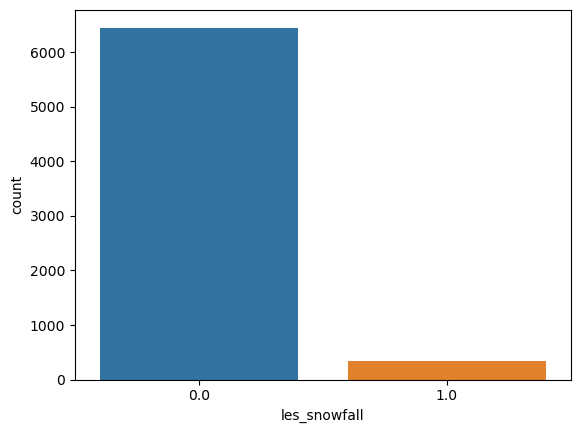

In [17]:
sns.countplot(shifted_df['les_snowfall'])

In [18]:
from collections import Counter
cnt = Counter(shifted_df['les_snowfall'])
cnt

Counter({0.0: 6450, 1.0: 342})

This is a clear indication of baised data, as there are many samples with zero as compared to one. In order for a decision tree to make accurate prediction, it should have equal number of positive and negative samples. <br>
Hence we will use weighted decision trees from sklearn to try to get a prediction closer to accurate.

## Splitting into train and test dataset

In [19]:
shifted_df.columns

Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'atm_press_hpa', 'sea_lev_press_hpa', 'mean',
       'centroid_lon', 'centroid_lat', 'std_lon', 'std_lat', 'skewness_lon',
       'skewness_lat', 'kurtosis_lon', 'kurtosis_lat', 'sample_number',
       'lake_visible', 'les_exist', 'les_snowfall'],
      dtype='object')

In [20]:
X_dev = ['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
        'visibility_mi', 'atm_press_hpa',
       'sea_lev_press_hpa', 'mean', 'centroid_lon',
       'centroid_lat', 'std_lon', 'std_lat', 'skewness_lon', 'skewness_lat',
       'kurtosis_lon', 'kurtosis_lat', 'lake_visible',
       'les_exist']

In [21]:
X = pd.DataFrame(shifted_df , columns = X_dev)
print("Independant variables : ")
print(X.columns)
y = shifted_df['les_snowfall']
print("Dependant variable : les_snowfall")

Independant variables : 
Index(['rh_%', 'dewpt_f', 'wind_spd_mph', 'wind_direction_deg',
       'visibility_mi', 'atm_press_hpa', 'sea_lev_press_hpa', 'mean',
       'centroid_lon', 'centroid_lat', 'std_lon', 'std_lat', 'skewness_lon',
       'skewness_lat', 'kurtosis_lon', 'kurtosis_lat', 'lake_visible',
       'les_exist'],
      dtype='object')
Dependant variable : les_snowfall


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Fitting the model

In [23]:
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced')

## Making Predictions

In [24]:
y_pred = model.predict(X_test)
print("R^2 : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 :  -0.6561172779922781
MAE : 0.07431935246504782
RMSE: 0.2726157597517939


In [25]:
from sklearn.metrics import accuracy_score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Let's check the overall accuracy.
trainaccuracy= accuracy_score(y_train, y_train_pred)
testaccuracy= accuracy_score(y_test, y_test_pred)

# Let us compare the values obtained for Train & Test:
print('Original Dataset Stats before Param Tuning')
print('-'*30)
print('On Train Data')
print('-'*30)
print("Accuracy    : {} %".format(round((trainaccuracy*100),2)))
print('-'*30)
print('On Test Data')
print('-'*30)
print("Accuracy    : {} %".format(round((testaccuracy*100),2)))
print('-'*30)

Original Dataset Stats before Param Tuning
------------------------------
On Train Data
------------------------------
Accuracy    : 100.0 %
------------------------------
On Test Data
------------------------------
Accuracy    : 92.57 %
------------------------------


## The tree

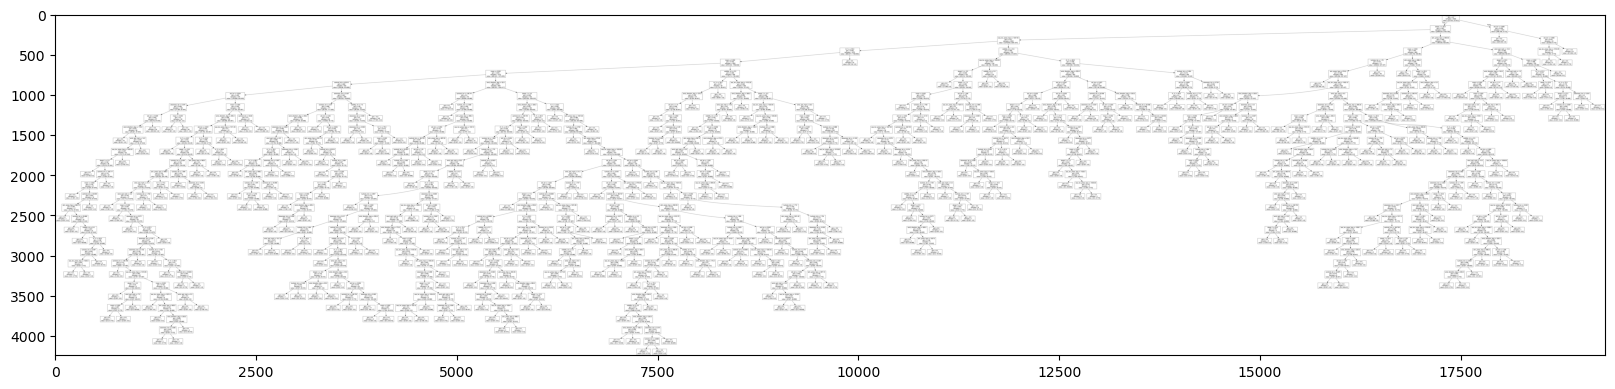

In [51]:
!dot -Tpng tree.dot -o tree.png

export_graphviz(model, 'tree.dot', feature_names = X_dev)
img = cv2.imread('tree.png')
#img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 0)
plt.figure(figsize = (20, 20))
plt.imshow(img)

## Hyperparameter Tuning with GridSearchCV

In [27]:
from sklearn.model_selection import GridSearchCV

Setting some initial values for max_depth, min_samples_leaf, min_samples_split and criterion to find the best fit

In [28]:
model_hp = DecisionTreeClassifier(class_weight='balanced',random_state=42)

params = {'max_depth':[3,5,7,10,15],
          'min_samples_leaf':[3,5,10,15,20],
          'min_samples_split':[8,10,12,18,20,16],
          'criterion':['gini','entropy']}
GS = GridSearchCV(estimator=model,param_grid=params,cv=5,n_jobs=-1, verbose=True, scoring='accuracy')

Splitting into test train datasets

In [29]:
## Splitting into test train

X = pd.DataFrame(shifted_df , columns = X_dev)
y = shifted_df['les_snowfall']
# Splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Fitting the Grid Search Model

In [30]:
GS.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10, 15],
                         'min_samples_leaf': [3, 5, 10, 15, 20],
                         'min_samples_split': [8, 10, 12, 18, 20, 16]},
             scoring='accuracy', verbose=True)

In [31]:
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 8}

Best Score: 0.831585742095178


Training the model and dumping it into pickle file

In [32]:
# dt_model = GS.best_estimator_
# with open('dt_model', 'wb') as files:
#     pickle.dump(dt_model, files)

Loading the model from pickle file:

In [33]:
with open('dt_model' , 'rb') as f:
    model = pickle.load(f)

In [34]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=3, min_samples_split=8)

### Making predictions

In [36]:
from sklearn.metrics import accuracy_score
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("R^2 : ", r2_score(y_test, y_test_pred))
print("MAE :", mean_absolute_error(y_test,y_test_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_test_pred)))

# Let's check the overall accuracy.
trainaccuracy= accuracy_score(y_train, y_train_pred)
testaccuracy= accuracy_score(y_test, y_test_pred)

# Let us compare the values obtained for Train & Test:
print('Stats after Param Tuning')
print('-'*30)
print('On Train Data')
print('-'*30)
print("Accuracy    : {} %".format(round((trainaccuracy*100),2)))
print('-'*30)
print('On Test Data')
print('-'*30)
print("Accuracy    : {} %".format(round((testaccuracy*100),2)))
print('-'*30)

R^2 :  -2.836944980694981
MAE : 0.17218543046357615
RMSE: 0.41495232312107394
Stats after Param Tuning
------------------------------
On Train Data
------------------------------
Accuracy    : 87.78 %
------------------------------
On Test Data
------------------------------
Accuracy    : 82.78 %
------------------------------


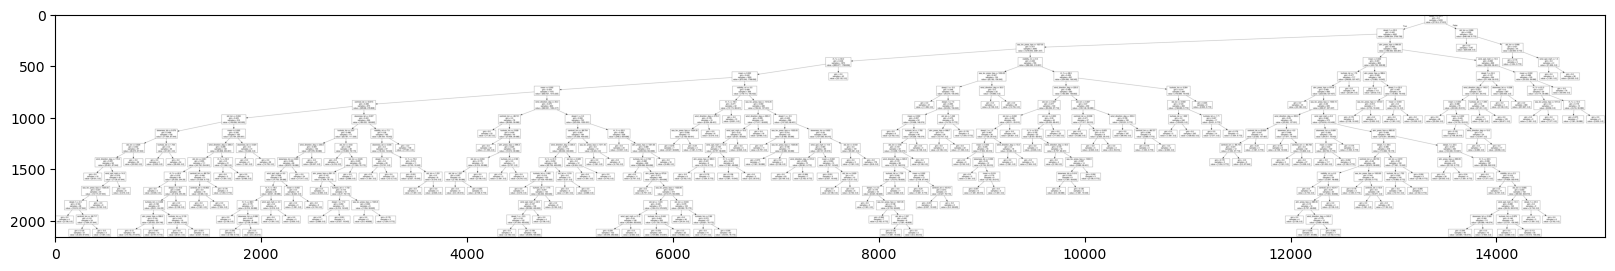

In [54]:
!dot -Tpng tree3.dot -o tree3.png

export_graphviz(model, 'tree3.dot', feature_names = X_dev)
img = cv2.imread('tree3.png')
#img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 0)
plt.figure(figsize = (20, 20))
plt.imshow(img)

## Conclusion

Before parameter tuning: <br>
We were able to achieve the accuracy of around 92% but the tree was deep and wide beyond explaination. <br>
After parameter tuning: <br>
We were able to achieve the accuracy of 93.24% but the still the tree looks deep and unexplainable. <br>
We increased the accuracy by tuning parameters but couldn't achieve explainability for the decision tree.
